# Lab 4 Confidence Intervals of Fits

## Table of Contents
1. **[Errors of Fits](#errors_of_fits)**  
    1.1 **[Confidence Intervals with TGraphs](#CI_TG)**  
    1.2 **[Confidence Intervals with TH1F and TH1D](#CI_TH1D)**  
    1.3 **[1.3 Exercise](#exercise)**

## 1. Errors of Fits <a name="errors_of_fits" />

### 1.1 Confidence Intervals with TGraphs <a name="CI_TG" />
When assessing the uncertainty of a fit, we can not simply use the error of the parameters to compute a 'band of error'. Each parameter is coorelated and their errors as a result are also coorelated. Therefore, we must use statistical analyses to compute these error bands at a certain confidence interval. To illustrate this concept, we will be using the ``TF1`` and ``TVirtualFitter`` classes from ``ROOT``.
First, we will start with the simplest example: fit a line to datapoints generated from a linear function smeared with a gaussian. 

In [1]:
// generate linear datapoints smeared with a gaussian
float m = 2.0f; // slope of the line
float b = 0.0f; // y-intercept of the line
int ngr = 100; // number of datapoints
TGraph graph(ngr);

for(int i = 0; i < ngr; i++) {
    float x = gRandom->Uniform(0,1); // randomly pick a value between 0 and 1
    float y = b + m * x + gRandom->Gaus(0,0.4); // evaluate function at x smear with a gaussian of mean 0, and sigma 0.4
    graph.SetPoint(i,x,y); // add the point to the TGraph
}

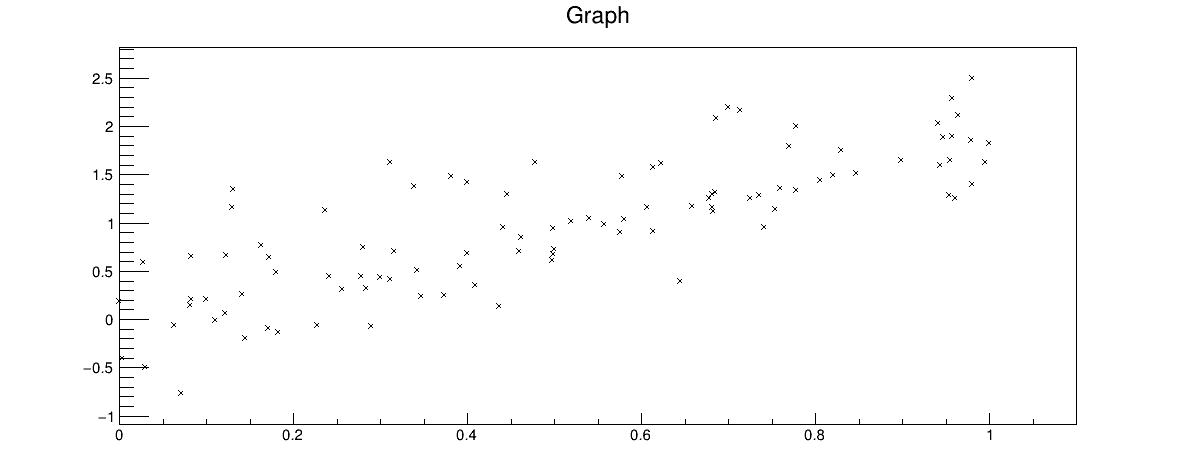

In [2]:
// Draw the TGraph 'gr'
TCanvas canvas("canvas_1", "Confidence intervals of the fitted function", 1200, 500);
graph.SetName("Graph Smeared w/ Gaussian");
graph.SetMarkerStyle(5);
graph.SetMarkerSize(0.7);
graph.Draw("AP");
canvas.Draw();

Now lets fit a line to these datapoints. Recall how the ``TF1`` class is constructed from Lab 2. Since we generated these datapoints, we know what the values of the final fit should be. We will set the initial values of our parameters to the values of the function we generated the points from.

In [3]:
// Create Fit Function
TF1 * fittingFunction = new TF1("linear", "[0]*x + [1]", 0, 1);
fittingFunction->SetParameter(0, 2);
fittingFunction->SetParameter(1, 0);

// Fit fitting function with TGraph
fittingFunction->SetLineWidth(2);
graph.Fit(fittingFunction, "S");

// Get the virtual fitter, which is our TF1 here. You wouldn't have to do this normally
// in ROOT as it would just get your last fitter, but we have separate code blocks and
// JupyROOT doesn't know where your last fitter is. Might be good practice though.
TVirtualFitter * virtFitter = TVirtualFitter::GetFitter();


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      17.0125
NDf                       =           98
Edm                       =   5.5114e-23
NCalls                    =           32
p0                        =       1.8667   +/-   0.140361    
p1                        =    0.0363716   +/-   0.0817599   


Once the function is fit to the datapoints of the TGraph, we can use ``TVirtualFitter`` and ``TGraphErrors`` to create a graph that holds the confidence intervals. We will compute the $95\%$ confidence interval of our fit, or the band where we are $95\%$ sure the fit lies within.

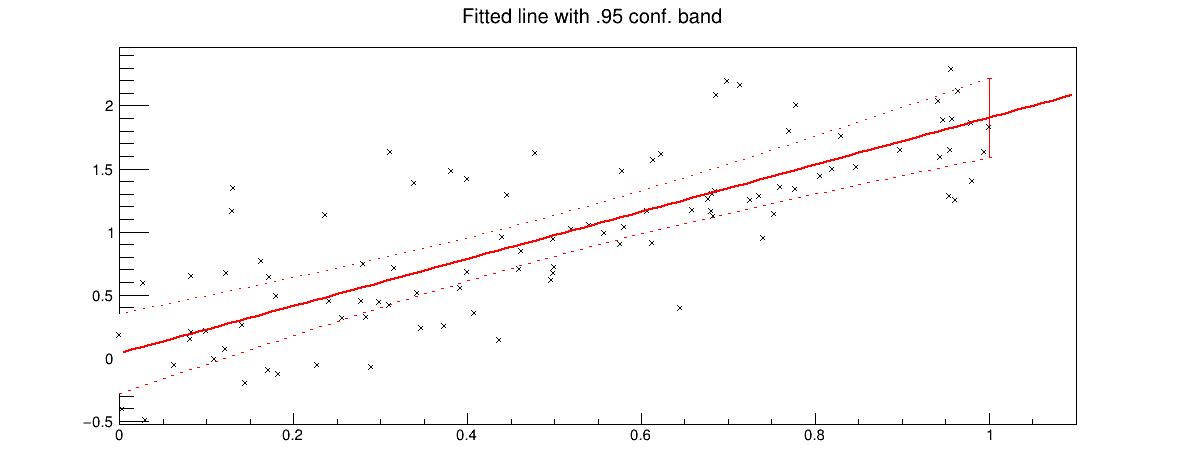

In [4]:
#include <vector>
using namespace std;

TGraphErrors * grint = new TGraphErrors(ngr);
grint->SetTitle("Fitted line with .95 conf. band");

vector<float> xValues;
float deltaX = 0.01;
for(int i = 0; i < 101; i++) {
    xValues.push_back(deltaX * i);
}

for(int i = 0; i < xValues.size(); i++) {
    grint->SetPoint(i, xValues[i], 0);
    // Compute CI at x points
    virtFitter->GetConfidenceIntervals(grint, 0.95);
    // Now 'grint' graph contains function values as y-coordinates
    // and confident intervals as the errors on these coordinates
    // Draw the graph, the function, and the confidence intervals
}
grint->SetLineColor(kRed);
grint->Draw("ap");
grint->Draw("E3same");
graph.SetMarkerStyle(5);
graph.SetMarkerSize(0.7);
graph.Draw("psame");
canvas.Draw();

Now, along with our fit, we have plotted the band of $95\%$ confidence. Now we will see this idea in the context of histograms which is more applicable in the field of HEP.

### 1.2 Confidence Intervals with TH1F and TH1D <a name="CI_TH1D" />
Let's begin by filling a histogram from a gaussian distribution.

In [1]:
TCanvas canvas2("canvas_2", "Confidence intervals of the fitted function", 1200, 500);

// Create histogram with 100 bins from -3 to 3
TH1F * hist = new TH1F("h", "Fitted Gaussian with a .95 conf. band", 100, -3, 3);
int numEvents = 5000; // 5000 events
hist->FillRandom("gaus", numEvents);

Now that we've filled the histogram from a random gaussian, lets create the fitting function. Since we filled it from a gaussian, we will fit it with the pre-defined ``TF1`` gaussian.

 FCN=101.673 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=4.35575e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.18688e+02   2.08841e+00   8.39022e-03  -1.16483e-04
   2  Mean         1.38603e-02   1.44112e-02   7.11043e-05  -8.14794e-03
   3  Sigma        9.90957e-01   1.04866e-02   1.40777e-05   1.47539e-02


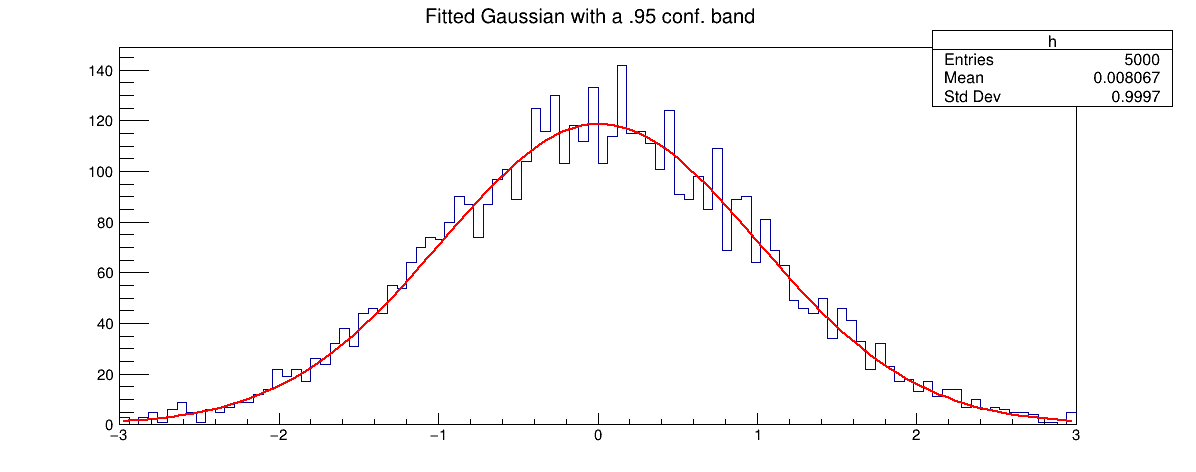

In [2]:
TF1 * gaussFunc = new TF1("fgaus", "gaus", -3, 3);
gaussFunc->SetLineWidth(2);
hist->Fit(fgaus);
hist->Draw();
canvas2.Draw();

TVirtualFitter * gaussVirtFitter = TVirtualFitter::GetFitter();

Now that we have filled the histogram and fitted it with a gaussian, let us now compute the $95\%$ confidence interval band. This is done very similarly to the way with` TGraphs`.The only difference is that we don't have to iterate through where to draw the confidence interval. 

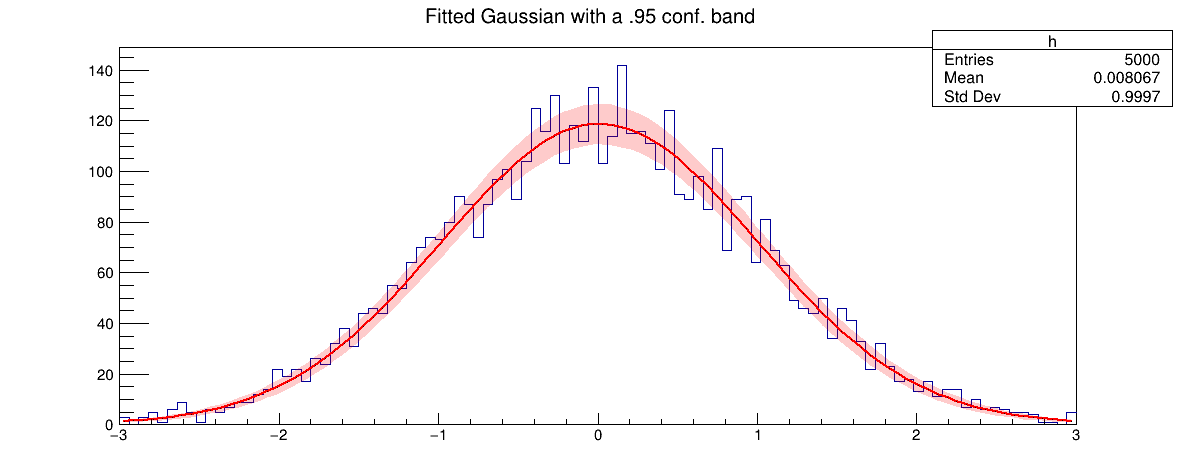

In [5]:
// Create Hist to hold confidence intervals
TH1D * histInterv = new TH1D("hint", "Fitted gaussian with a .95 conf. band", 100, -3, 3);
gaussVirtFitter->GetConfidenceIntervals(histInterv);
// Now the 'hint' histogram has the fitted function values
// as the bin contents and the CI as bin errors
histInterv->SetStats(kFALSE);
Int_t fFillColor = TColor::GetColorTransparent(kRed, 0.2);
histInterv->SetFillColor(fFillColor);
// Must Draw in this order since we want the axis range to be determined from hist
// since using an transparent fill color, hist must be drawn on-top of hint
hist->Draw();
histInterv->Draw("e3same");
canvas2.Draw();

### 1.3 Exercise <a name="exercise" />

Generate a random scatterplot of 200 points from a line of slope $5$, and y-intercept of $-2$ smeared with a gaussian of mean $0$, and sigma $1$ over $x=(-5,5)$. Then fit a line to this scatterplot and plot the $90\%$ confidence interval band.

In [ ]:
TCanvas canvas3("canvas_2", "Confidence intervals of the fitted function", 1200, 500);
canvas3.divide(2, 1);
canvas3.cd(1);

Generate a histogram with 100 bins from 0 to 5, and randomly fill it with 10000 entries from $f(x) = e^{-5x}$. Then fit this histogram with an exponential and find the $80\%$ confidence interval band.

In [ ]:
canvas3.cd(2);
    


canvas3.Draw();